In [1]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
import tqdm.notebook as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from multiprocessing import Pool
import shutil


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

import threading

import json

# from segmentation_models_pytorch.encoders import get_preprocessing_fn
# preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
from whuvid_dataset import WhuvidDataset
from kitti_dataset import KittiDataset

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
import ptlflow
from ptlflow.utils import flow_utils
from ptlflow.utils.io_adapter import IOAdapter

ERROR: torch_scatter not found. CSV requires torch_scatter library to run. Check instructions at: https://github.com/rusty1s/pytorch_scatter


In [4]:
root_path = "/home/thiago/Workspace/motion-segmentation/datasets/WHUVID"
# sequences = ["01", "17", "18", "19", "20", "22", "23", "24", "25", "30", "31", "32"]
sequences = ["20"]
# sequences = ["01"]

In [5]:
def image_list_from_file(path):
    with open(path) as f:
        lines = f.readlines()
    lines = [line.rstrip() for line in lines]
    # remove first 3 (header)
    return lines[3:]

def get_next_image_path(image_list, image_path, diff):
    # find index of image_path in image_list
    # remove everything before "cam0"
    relative_path = image_path[image_path.find("cam0"):]
    # get everything before cam0
    root = image_path[:image_path.find("cam0")]
    idx = image_list.index(relative_path)
    # return None if image_path is one of the last images
    image_diff = diff
    if idx >= (len(image_list) - image_diff):
        return None
    next_image_path = os.path.join(root, image_list[idx+image_diff])
    # check if image exists
    if not os.path.exists(next_image_path):
        return None
    return next_image_path

def get_files(root_path, cam):
    images = []
    image_list = image_list_from_file(os.path.join(root_path, "other_files/image.txt"))
    images_path = os.path.join(root_path, cam)
    for root, dirs, files in os.walk(images_path):
        for file in files:
            full_path = os.path.join(root, file)
            next_image = get_next_image_path(image_list, full_path, 10)
            if full_path.endswith(".png")and next_image is not None:
                # prevent !_src.empty()
                # img = cv2.imread(full_path)
                # if img is None:
                #     continue
                images.append(full_path)
    return images

In [6]:
# model = ptlflow.get_model('dicl', pretrained_ckpt='kitti').cuda()
model = ptlflow.get_model('dicl', pretrained_ckpt='kitti').cuda()

/home/thiago/Workspace/motion-segmentation/src/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


In [7]:
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.RandomResizedCrop(size=224, scale=(0.4, 1.0)
    #                             #  , ratio=(0.5, 2)
    #                              ),
    # resize to 224x224
    # transforms.Resize((512, 512)),
    # transforms.Resize((height, width)),
    transforms.ToTensor()
])
kitti_path = "/home/thiago/Workspace/motion-segmentation/datasets/KITTI-Motion"
kitti = KittiDataset(kitti_path, transform, is_train=True, flow=False, segmentation=False, next_frame=True)

In [8]:
len(kitti.images)

273

torch.Size([1, 1, 2, 384, 1280])


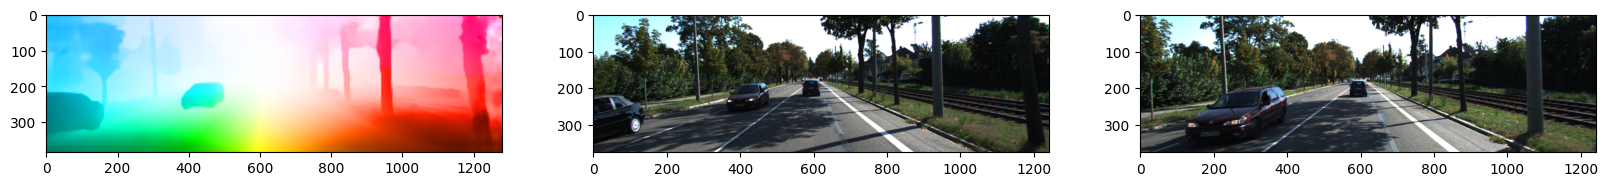

In [9]:
i = 40
image_path = kitti.images[i]
next_image_path = kitti.next_image_path(kitti.images[i], 2)
prev_image_bgr = cv2.imread(image_path)
next_image_bgr = cv2.imread(next_image_path)

flow_path = image_path.replace('train', 'flow_v6')

height, width, _ = prev_image_bgr.shape
factor = 1
target_height, target_width = round(height//factor), round(width//factor)
# target_height, target_width = height, width
prev_image_bgr = cv2.resize(prev_image_bgr, (target_width, target_height))
next_image_bgr = cv2.resize(next_image_bgr, (target_width, target_height))

imgs = [prev_image_bgr, next_image_bgr]
io_adapter = IOAdapter(model, imgs[0].shape[:2])
inputs = io_adapter.prepare_inputs(imgs)
inputs['images'] = inputs['images'].cuda()
# predictions = model(inputs)

predictions = model(inputs)

flows = predictions['flows']
print(flows.shape)
flow_rgb = flow_utils.flow_to_rgb(flows, flow_max_radius=150)
# Make it a numpy array with HWC shape
flow_rgb = flow_rgb[0, 0].permute(1, 2, 0)
flow = flow_rgb.detach().cpu().numpy()
# OpenCV uses BGR format
# flow_bgr_npy = cv2.cvtColor(flow_rgb_npy, cv2.COLOR_RGB2BGR)


# to rgb
prev_image_rgb = cv2.cvtColor(prev_image_bgr, cv2.COLOR_BGR2RGB)
# to float
prev_image_rgb = prev_image_rgb.astype(np.float32) / 255.0
next_image_rgb = cv2.cvtColor(next_image_bgr, cv2.COLOR_BGR2RGB)
next_image_rgb = next_image_rgb.astype(np.float32) / 255.0


# Plot
# plt.figure(figsize=(10, 10))
# plt.imshow(flow)
# plt.show()

# # img_with_flow = cv2.addWeighted(prev_image_rgb, 1, flow, 0.8, 0)
# plt.figure(figsize=(10, 10))
# plt.imshow(prev_image_rgb)
# plt.show()

# plot flow and prev_image_rgb and next_image_rgb
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(flow)
ax[1].imshow(prev_image_rgb)
ax[2].imshow(next_image_rgb)
plt.show()

In [10]:
def flow_single_image(path):
    try:
        next_image_path = kitti.next_image_path(path, 2)
        flow_path = path.replace('train', 'flow_v6')

        # extract dir and create if not exists
        # flow_dir = os.path.dirname(flow_path)
        # recursively remove flow_dir
        # if not os.path.exists(flow_dir):
        #     os.makedirs(flow_dir, exist_ok=True)
        # get next image name
        # root_path is all before "cam0"
        # compute flow
        if next_image_path is None:
            return
        prev_image = cv2.imread(path)
        next_image = cv2.imread(next_image_path)

        if prev_image is None or next_image is None:
            return

        imgs = [prev_image, next_image]
        io_adapter = IOAdapter(model, imgs[0].shape[:2])
        inputs = io_adapter.prepare_inputs(imgs)
        inputs['images'] = inputs['images'].cuda()

        predictions = model(inputs)
        flows = predictions['flows']
        flow_rgb = flow_utils.flow_to_rgb(flows, flow_max_radius=150)
        # Make it a numpy array with HWC shape
        flow_rgb = flow_rgb[0, 0].permute(1, 2, 0)
        flow = flow_rgb.detach().cpu().numpy()
        # OpenCV uses BGR format
        flow = cv2.cvtColor(flow, cv2.COLOR_RGB2BGR)
        # to 0-255
        flow = (flow * 255).astype(np.uint8)
        # return to original size
        # flow = cv2.resize(flow, (width, height))
        # save flow image
        flow_dir = os.path.dirname(flow_path)
        if not os.path.exists(flow_dir):
            os.makedirs(flow_dir, exist_ok=True)
        cv2.imwrite(flow_path, flow)
        
        
        # free memory
        del prev_image
        del next_image
        del flow
        del flow_rgb
        del flows
        del predictions
        del inputs
        del imgs
        gc.collect()
    except Exception as e:
        print(f"Skipping {path} due to {e}\n")
# using pool, with tqdm
# with Pool(28) as p:
#     list(tq.tqdm(p.imap(flow_single_image, images), total=len(images)))\

# without pool
for i, image in tq.tqdm(enumerate(kitti.images), total=len(kitti.images)):
    flow_single_image(image)

  0%|          | 0/273 [00:00<?, ?it/s]

[ WARN:0@6.058] global loadsave.cpp:241 findDecoder imread_('/home/thiago/Workspace/motion-segmentation/datasets/KITTI-Motion/train/2011_09_26_drive_0056_sync/left/0000000295.png'): can't open/read file: check file path/integrity
[ WARN:0@6.275] global loadsave.cpp:241 findDecoder imread_('/home/thiago/Workspace/motion-segmentation/datasets/KITTI-Motion/train/2011_09_26_drive_0056_sync/left/0000000097.png'): can't open/read file: check file path/integrity
[ WARN:0@7.543] global loadsave.cpp:241 findDecoder imread_('/home/thiago/Workspace/motion-segmentation/datasets/KITTI-Motion/train/2011_09_26_drive_0056_sync/left/0000000137.png'): can't open/read file: check file path/integrity
[ WARN:0@10.409] global loadsave.cpp:241 findDecoder imread_('/home/thiago/Workspace/motion-segmentation/datasets/KITTI-Motion/train/2011_09_26_drive_0056_sync/left/0000000138.png'): can't open/read file: check file path/integrity
